In [1]:
from __future__ import division
import matplotlib.pylab as plt
%matplotlib inline
import numpy as np
import os
import pandas as pd
from scipy.stats import linregress
import nibabel as nib
import urllib
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook')
import scipy 
import copy
import mne
from scipy.stats import linregress, pearsonr, spearmanr

### Load in data

In [313]:
behav_data_f = '../../Phenotypic_V1_0b_preprocessed1.csv'
df = pd.read_csv(behav_data_f)
df = df.loc[df['func_perc_fd'].notnull(), :]
df = df.loc[df['FILE_ID']!='no_filename', :]
df['AGE_YRS'] = np.floor(df['AGE_AT_SCAN'])
df= df.loc[(df['AGE_YRS']>=6)& (df['AGE_YRS']<=18), :] #only include kids
#df  df.loc[df['func_perc_fd'] < .5, :] ## play around with motion threshold?                                   

### Across everyone, what roi-roi pairs get stronger or weaker with age?

#### note - we are going to take out people with nans for this

In [300]:
def make_group_corr_mat(df):
    """
    This function reads in each subject's aal roi time series files and creates roi-roi correlation matrices
    for each subject and then sums them all together. The final output is a 3d matrix of all subjects 
    roi-roi correlations, a mean roi-roi correlation matrix and a roi-roi covariance matrix. 
    **NOTE WELL** This returns correlations transformed by the Fisher z, aka arctanh, function.    
    """

    for i, (sub, f_id) in enumerate(df[['SUB_ID', 'FILE_ID']].values):
        
        # read each subjects aal roi time series files
        ts_df = pd.read_table('DATA/{}_rois_aal.1D'.format(f_id))

        # create a correlation matrix from the roi all time series files
        corr_mat_r = ts_df.corr()
        
        # the correlations need to be transformed to Fisher z, which is
        # equivalent to the arctanh function.
        corr_mat_z = np.arctanh(corr_mat_r)
        
        # for the first subject, create a correlation matrix of zeros
        # that is the same dimensions as the aal roi-roi matrix
        if i == 0:
            all_corr_mat = np.zeros([corr_mat_z.shape[0], corr_mat_z.shape[1], len(df)])
        
        ## if correlation matrix DOESNT have nans,
        ## add the correlation matrix you just created for each subject to the all_corr_mat matrix (3D)
        n_nan = np.sum(np.sum(corr_mat_r.isnull()))
        if n_nan == 0:
            all_corr_mat[:, :, i] = corr_mat_z
            
        # If there are any NaNs then print the subject id
        n_nan = np.sum(np.sum(corr_mat_r.isnull()))
        if n_nan > 0:
            print 'SUB has NaNs: {}'.format(f_id)
            
    # create the mean correlation matrix (ignore nas - sometime there are some...)
    av_corr_mat = np.nanmean(all_corr_mat, axis=2)
    # create the group covariance matrix (ignore nas - sometime there are some...)
    var_corr_mat = np.nanvar(all_corr_mat, axis=2)
        
    return all_corr_mat, av_corr_mat, var_corr_mat

def corr_w_age(df, M_all):
    # We want to fill in a correlation matrix with the correlation
    # with age for all the roi-roi pairs.
    # We want to know the r, p and m (slope) values:
    # Lets start by making the output arrays
    # (originally filled with zeros)
    age_roi_corr_r =np.zeros((116,116))
    age_roi_corr_p =np.zeros((116,116))
    age_roi_corr_m =np.zeros((116,116))

    # The age for your participants stays the same at all times!
    # So we just need one array with their values
    age=df.loc[:, 'AGE_AT_SCAN'].values

    # BUT we want to loop through all the roi-roi pairs. 
    # There's no need to do the calculation for the bottom part of
    # the triangle as it is symmetric.
    i_list, j_list = np.triu_indices(116, k=1)

    # Now, loop through all the pairs and fill in the pearson
    # correlation for all regions
    for i, j in zip(i_list, j_list):
        age_roi_corr_r[i, j] = pearsonr(M_all[i, j, :], age)[0]
        age_roi_corr_p[i, j] = pearsonr(M_all[i, j, :], age)[1]
        age_roi_corr_m[i, j] = linregress(M_all[i, j, :], age)[0]
    
    # Finally, flip the correlation values to the bottom triangle
    age_roi_corr_r = age_roi_corr_r + age_roi_corr_r.T
    age_roi_corr_p = age_roi_corr_p + age_roi_corr_p.T
    age_roi_corr_m = age_roi_corr_m + age_roi_corr_m.T
    
    
    return age_roi_corr_r, age_roi_corr_p, age_roi_corr_m

In [301]:
all_corr_mat, av_corr_mat, var_corr_mat= make_group_corr_mat(df)


/Users/Jlnrd/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:19: RuntimeWarning: divide by zero encountered in arctanh


SUB has NaNs: Pitt_0050007
SUB has NaNs: Pitt_0050011
SUB has NaNs: Pitt_0050026
SUB has NaNs: Pitt_0050028
SUB has NaNs: Pitt_0050035
SUB has NaNs: Pitt_0050045
SUB has NaNs: Pitt_0050050
SUB has NaNs: Pitt_0050053
SUB has NaNs: SDSU_0050182
SUB has NaNs: SDSU_0050184
SUB has NaNs: SDSU_0050192
SUB has NaNs: SDSU_0050195
SUB has NaNs: SDSU_0050209
SUB has NaNs: SDSU_0050210
SUB has NaNs: SDSU_0050216
SUB has NaNs: Leuven_2_0050727
SUB has NaNs: KKI_0050790
SUB has NaNs: KKI_0050793
SUB has NaNs: KKI_0050815
SUB has NaNs: NYU_0051033
SUB has NaNs: NYU_0051036
SUB has NaNs: NYU_0051100
SUB has NaNs: Caltech_0051487


In [302]:
age_roi_corr_r, age_roi_corr_p, age_roi_corr_m=corr_w_age(df, all_corr_mat)


# Across all children in ABIDE, Which ROI-ROI connections correlate with age?


In [303]:
# add aal labels?
aal_labels = 'aal_labels.csv'
df = pd.read_csv(aal_labels )
#df.head()
labels =df.loc[:, 'name']


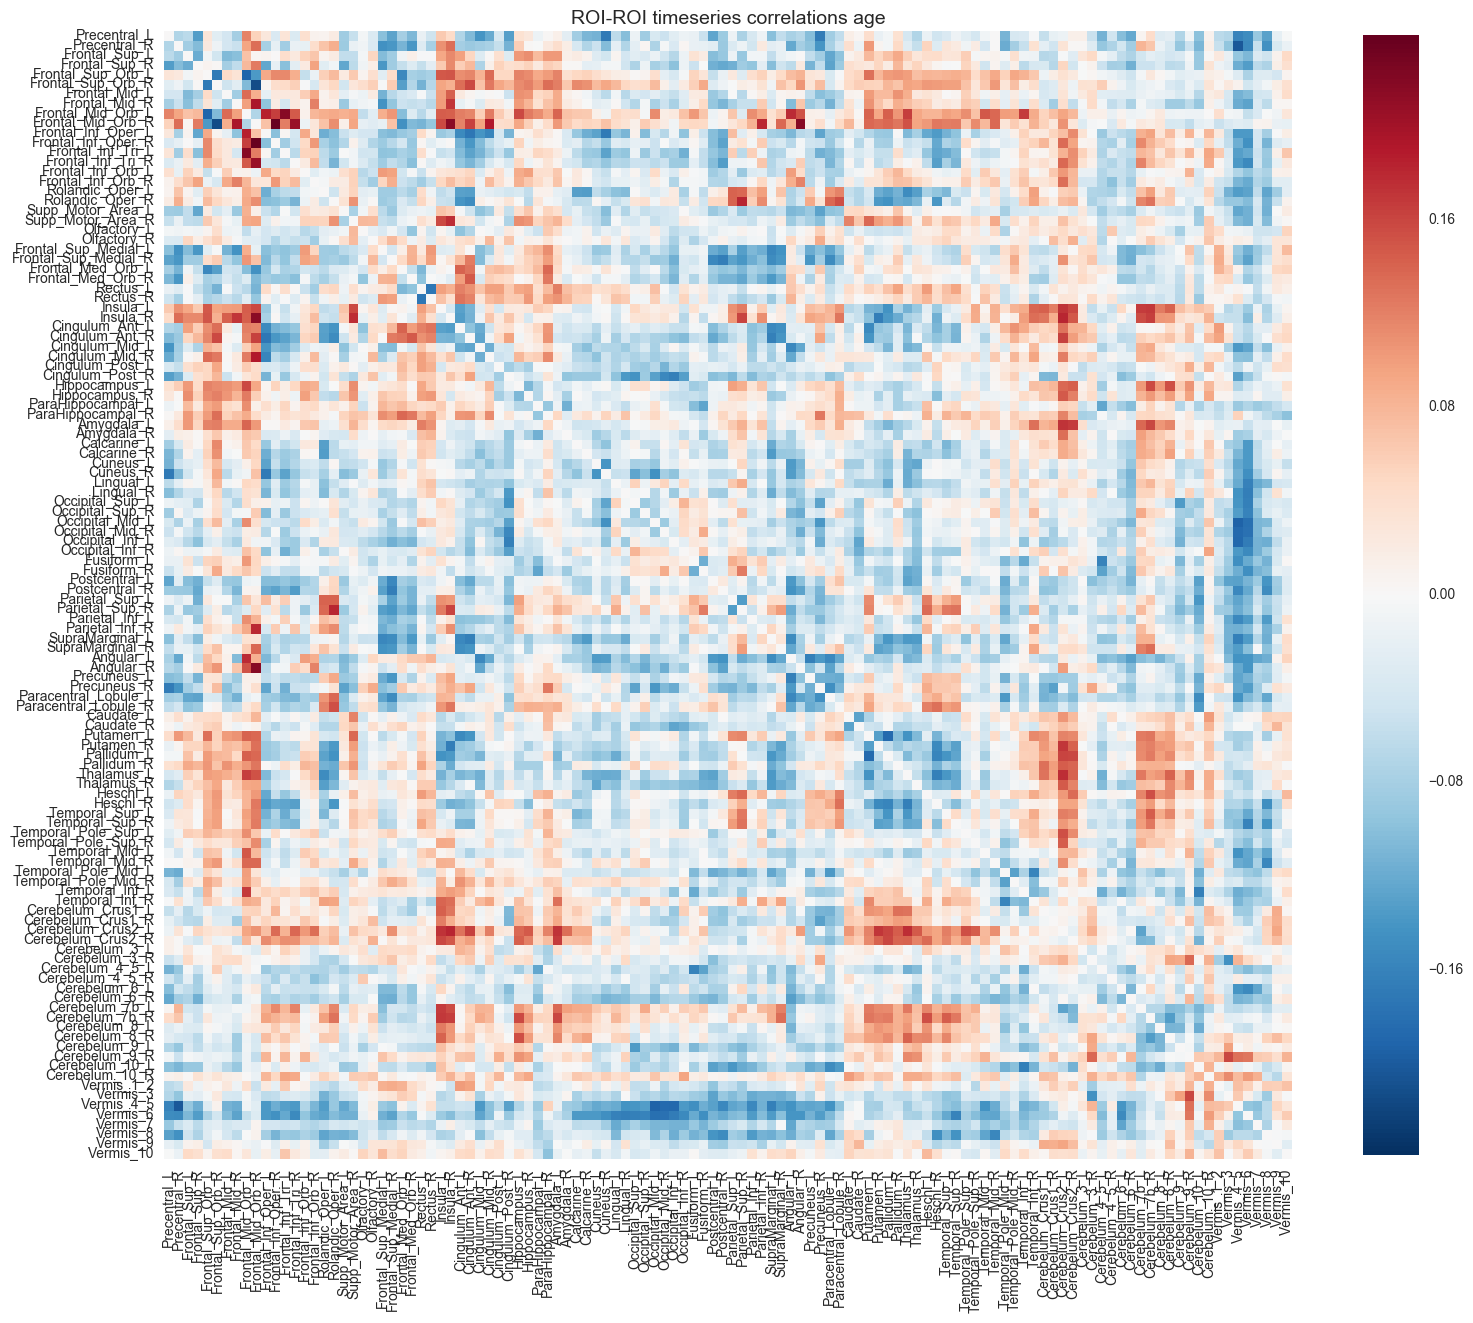

In [304]:
corr=age_roi_corr_r
import matplotlib.pyplot as plt
from matplotlib.colorbar import make_axes
sns.set(style="darkgrid")

sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 2.5})
f, ax = plt.subplots(figsize=(16, 16))
ax.set_title('ROI-ROI timeseries correlations age',fontdict={'fontsize': 14})
sns.color_palette("RdBu_r")
sns.heatmap(corr, square=True, ax=ax, xticklabels=list(labels),yticklabels=list(labels),cbar_kws={'shrink':0.73})
f.tight_layout()
f.savefig('rs_SSI_chart', dpi=600, frameon=False,transparent=True,edgecolor='k',facecolor='w')#facecolor='w', , pad_inches=5)

# Let's order the all atlas by L and R and lobe!

In [202]:
# add aal labels?
aal_labels = 'aal_labels.csv'
df = pd.read_csv(aal_labels )
#df.head()
labels =df.loc[:, 'name']
lobe =df.loc[:, 'lobe_order'].values[:-26]


In [203]:
##read in one persons aal data
test = pd.read_csv('DATA/Pitt_0050059_rois_aal.1D', sep='\t') 
labels = labels[: -26]
test = test.ix[:, :-26] #taking out cerrebellum!
test.columns=labels
test.head()

name,Precentral_L,Precentral_R,Frontal_Sup_L,Frontal_Sup_R,Frontal_Sup_Orb_L,Frontal_Sup_Orb_R,Frontal_Mid_L,Frontal_Mid_R,Frontal_Mid_Orb_L,Frontal_Mid_Orb_R,...,Temporal_Sup_L,Temporal_Sup_R,Temporal_Pole_Sup_L,Temporal_Pole_Sup_R,Temporal_Mid_L,Temporal_Mid_R,Temporal_Pole_Mid_L,Temporal_Pole_Mid_R,Temporal_Inf_L,Temporal_Inf_R
0,-2.604185,2.377032,3.744340,1.197979,-6.167321,-12.563662,-2.211212,-2.293051,-4.637430,-6.131273,...,4.333373,16.610482,13.162504,9.415358,4.193991,6.004144,-0.143133,5.779267,-1.643117,-0.626666
1,-3.830359,3.230388,4.082725,0.668375,-6.374774,-12.547712,-3.780959,-4.328287,-5.208597,-4.413556,...,2.473538,20.681493,15.227696,7.671138,4.196570,8.892538,0.137270,7.281653,-2.142610,-1.173529
2,-5.706779,2.941397,1.859788,-0.167470,-4.769674,-8.685178,-5.667676,-6.024410,-4.117164,-1.798133,...,-2.922499,15.754672,11.166885,0.098177,3.273617,8.612667,-0.140903,6.481803,-2.031902,-1.446731
3,-7.983104,2.011812,-2.485685,-1.054942,-2.476610,-2.744068,-7.460251,-6.406447,-2.331460,-0.446636,...,-8.817397,3.953484,1.618096,-11.041742,2.110480,5.648213,-1.220895,3.314893,-1.530640,-1.064541
4,-9.446753,1.735974,-6.882683,-1.346238,-0.681639,3.220673,-8.254388,-4.746043,-0.662182,-1.314318,...,-11.348222,-8.465535,-9.302574,-20.437511,1.784920,2.434227,-2.449458,-0.723977,-0.766342,0.273861


### Create L and R lobe masks

In [204]:
masks = ['left' if '_L' in x[-2:] else 'right' for x in labels] 

### Add columns with lobe and L, R masks to data

In [208]:
test.loc[196, :] = test.columns.values
test.loc[197, :] = lobe
test.loc[198,:]=masks

### Create L and R lobe groups

In [209]:
groups = test.T.groupby(198)#make R and L hemi groups
right=groups.get_group('right') 
left = groups.get_group('left')

### Create seperate data frames for each lobe by each hemisphere. At the end, add them back up all together in the order you want!

#### make sure to drop the extra column labels of the hemis and lobes first though!

In [250]:
#RIGHT
groups = right.groupby(197)
parietal_R=groups.get_group('Parietal').drop([196,197,198],1).T 
frontal_R = groups.get_group('frontal').drop([196,197,198],1).T
occipital_R=groups.get_group('occipital').drop([196,197,198],1).T  
temporal_R = groups.get_group('temporal').drop([196,197,198],1).T 
subcortex_R = groups.get_group('subcortex').drop([196,197,198],1).T 

#LEFT
groups = left.groupby(197)
parietal_L=groups.get_group('Parietal').drop([196,197,198],1).T   
frontal_L = groups.get_group('frontal').drop([196,197,198],1).T  
occipital_L=groups.get_group('occipital').drop([196,197,198],1).T   
temporal_L = groups.get_group('temporal').drop([196,197,198],1).T  
subcortex_L = groups.get_group('subcortex').drop([196,197,198],1).T  

#put them all together!
ordered_df=pd.concat([
        frontal_R, parietal_R, temporal_R, occipital_R, subcortex_R,
        frontal_L, parietal_L, temporal_L,occipital_L, subcortex_L
    ], axis=1).astype(float)

ordered_df.head()

name,Precentral_R,Frontal_Sup_R,Frontal_Sup_Orb_R,Frontal_Mid_R,Frontal_Mid_Orb_R,Frontal_Inf_Oper_R,Frontal_Inf_Tri_R,Frontal_Inf_Orb_R,Rolandic_Oper_R,Supp_Motor_Area_R,...,Cingulum_Ant_L,Cingulum_Mid_L,Cingulum_Post_L,Hippocampus_L,ParaHippocampal_L,Amygdala_L,Caudate_L,Putamen_L,Pallidum_L,Thalamus_L
0,2.377032,1.197979,-12.563662,-2.293051,-6.131273,-10.967519,-1.184041,-3.187622,8.184591,11.442228,...,15.805925,8.966897,7.924148,8.709614,16.265270,53.172669,2.127507,5.834413,5.784880,2.344478
1,3.230388,0.668375,-12.547712,-4.328287,-4.413556,-11.804488,-1.350994,-10.026639,10.473644,16.515764,...,16.424996,8.405615,9.691073,11.516874,24.416233,60.596751,-1.254296,4.990322,-1.049216,0.651221
2,2.941397,-0.167470,-8.685178,-6.024410,-1.798133,-9.147273,-2.545926,-18.145874,6.812927,17.261627,...,11.263068,4.734872,6.640820,11.580960,24.549740,46.456919,-5.919872,1.485141,-11.785337,-3.117689
3,2.011812,-1.054942,-2.744068,-6.406447,-0.446636,-4.327289,-4.003125,-24.059287,-2.495433,13.352111,...,2.615979,-0.066291,0.365733,8.233049,13.940788,13.597782,-9.432123,-2.270658,-21.537735,-7.028215
4,1.735974,-1.346238,3.220673,-4.746043,-1.314318,0.967643,-4.174245,-23.829964,-13.465240,7.494380,...,-5.522227,-3.621616,-5.483854,2.681817,-4.348882,-24.823410,-9.481016,-3.715669,-24.864206,-8.668413


### Does correlation matrix look right in one subject?

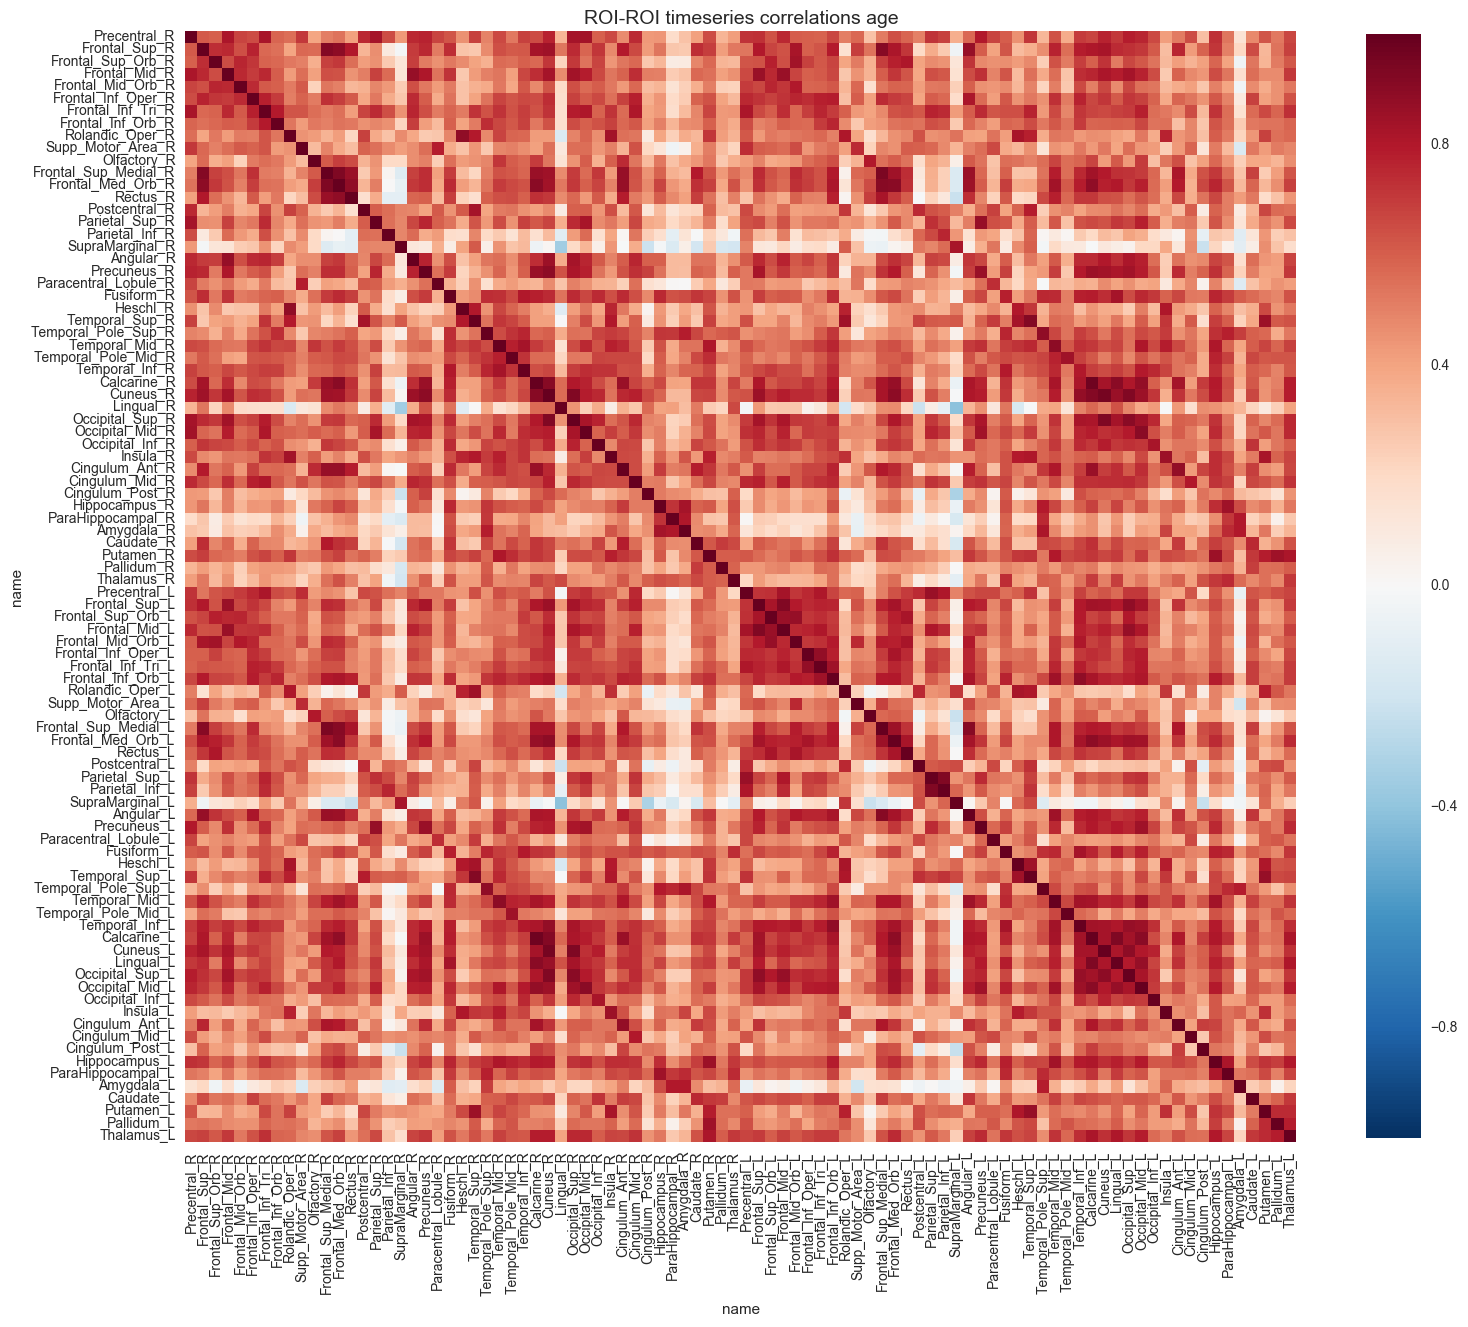

In [251]:
corr=ordered_df.corr()
labels =ordered_df.columns
import matplotlib.pyplot as plt
from matplotlib.colorbar import make_axes
sns.set(style="darkgrid")

sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 2.5})
f, ax = plt.subplots(figsize=(16, 16))
ax.set_title('ROI-ROI timeseries correlations age',fontdict={'fontsize': 14})
sns.color_palette("RdBu_r")
sns.heatmap(corr, square=True, ax=ax, xticklabels=list(labels),yticklabels=list(labels),cbar_kws={'shrink':0.73})
f.tight_layout()
f.savefig('rs_SSI_chart', dpi=600, frameon=False,transparent=True,edgecolor='k',facecolor='w')#facecolor='w', , pad_inches=5)

### wrap this into a function!

In [45]:
aal_labels = 'aal_labels.csv'
df = pd.read_csv(aal_labels )
labels =df.loc[:, 'name']
lobe =df.loc[:, 'lobe_order'].values[:-26]
labels = labels[: -26]

def order_data(df, lobe, labels):
    test = df.ix[:, :-26] #taking out cerrebellum!
    test.columns=labels
    masks = ['left' if '_L' in x[-2:] else 'right' for x in labels] 
    test.loc[196, :] = test.columns.values
    test.loc[197, :] = lobe
    test.loc[198, :] = masks
    groups = test.T.groupby(198)#make R and L hemi groups
    right=groups.get_group('right') 
    left = groups.get_group('left')
    
    #RIGHT
    groups = right.groupby(197)
    parietal_R=groups.get_group('Parietal').drop([196,197,198],1).T 
    frontal_R = groups.get_group('frontal').drop([196,197,198],1).T
    occipital_R=groups.get_group('occipital').drop([196,197,198],1).T  
    temporal_R = groups.get_group('temporal').drop([196,197,198],1).T 
    subcortex_R = groups.get_group('subcortex').drop([196,197,198],1).T 

    #LEFT
    groups = left.groupby(197)
    parietal_L=groups.get_group('Parietal').drop([196,197,198],1).T   
    frontal_L = groups.get_group('frontal').drop([196,197,198],1).T  
    occipital_L=groups.get_group('occipital').drop([196,197,198],1).T   
    temporal_L = groups.get_group('temporal').drop([196,197,198],1).T  
    subcortex_L = groups.get_group('subcortex').drop([196,197,198],1).T  

    #put them all together!
    ordered_df=pd.concat([
            frontal_R, parietal_R, temporal_R, occipital_R, subcortex_R,
            frontal_L, parietal_L, temporal_L,occipital_L, subcortex_L
        ], axis=1).astype(float)

    return ordered_df, ordered_df.columns.values

In [46]:
data = pd.read_csv('DATA/Pitt_0050059_rois_aal.1D', sep='\t') 
output=order_data(data,lobe,labels)
output.head()

/Users/Jlnrd/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


AttributeError: 'tuple' object has no attribute 'head'

# Order by lobe and hemi in roi-roi and age correlation function!

In [47]:
## load in data again
behav_data_f = '../../Phenotypic_V1_0b_preprocessed1.csv'
df = pd.read_csv(behav_data_f)
df = df.loc[df['func_perc_fd'].notnull(), :]
df = df.loc[df['FILE_ID']!='no_filename', :]
df['AGE_YRS'] = np.floor(df['AGE_AT_SCAN'])
df= df.loc[(df['AGE_YRS']>=6)& (df['AGE_YRS']<=18), :] #only include kids
#df  df.loc[df['func_perc_fd'] < .5, :] ## play around with motion threshold? 
data_test=df.loc[3:5,:]

In [48]:
## define lobe and labels for label for loop below
aal_labels = 'aal_labels.csv'
df_aal = pd.read_csv(aal_labels )
labels =df_aal.loc[:, 'name']
lobe =df_aal.loc[:, 'lobe_order'].values[:-26]
labels = labels[: -26]


In [63]:
def make_group_corr_mat(df,lobe,labels):
    """
    This function reads in each subject's aal roi time series files and creates roi-roi correlation matrices
    for each subject and then sums them all together. The final output is a 3d matrix of all subjects 
    roi-roi correlations, a mean roi-roi correlation matrix and a roi-roi covariance matrix. 
    **NOTE WELL** This returns correlations transformed by the Fisher z, aka arctanh, function.    
    """

    for i, (sub, f_id) in enumerate(df[['SUB_ID', 'FILE_ID']].values):
        
        # read each subjects aal roi time series files
        ts_df = pd.read_table('DATA/{}_rois_aal.1D'.format(f_id))
        
        ##order df by lob and hemi
        df_order, labs=order_data(ts_df, lobe, labels)
        
        # create a correlation matrix from the roi all time series files
        corr_mat_r = df_order.corr()
        
        # the correlations need to be transformed to Fisher z, which is
        # equivalent to the arctanh function.
        corr_mat_z = np.arctanh(corr_mat_r)
        
        # for the first subject, create a correlation matrix of zeros
        # that is the same dimensions as the aal roi-roi matrix
        if i == 0:
            all_corr_mat = np.zeros([corr_mat_z.shape[0], corr_mat_z.shape[1], len(df)])
        
        ## if correlation matrix DOESNT have nans,
        ## add the correlation matrix you just created for each subject to the all_corr_mat matrix (3D)
        n_nan = np.sum(np.sum(corr_mat_r.isnull()))
        if n_nan == 0:
            all_corr_mat[:, :, i] = corr_mat_z
            
        # If there are any NaNs then print the subject id
        n_nan = np.sum(np.sum(corr_mat_r.isnull()))
        if n_nan > 0:
            print 'SUB has NaNs: {}'.format(f_id)
            
    # create the mean correlation matrix (ignore nas - sometime there are some...)
    av_corr_mat = np.nanmean(all_corr_mat, axis=2)
    # create the group covariance matrix (ignore nas - sometime there are some...)
    var_corr_mat = np.nanvar(all_corr_mat, axis=2)
        
    return all_corr_mat, av_corr_mat, var_corr_mat, labs

In [67]:
def corr_w_age(df, M_all):
    # We want to fill in a correlation matrix with the correlation
    # with age for all the roi-roi pairs.
    # We want to know the r, p and m (slope) values:
    # Lets start by making the output arrays
    # (originally filled with zeros)
    age_roi_corr_r =np.zeros((90,90)) ##NOT INCLUDING CEREBELLUM!!!!
    age_roi_corr_p =np.zeros((90,90))
    age_roi_corr_m =np.zeros((90,90))

    # The age for your participants stays the same at all times!
    # So we just need one array with their values
    age=df.loc[:, 'AGE_AT_SCAN'].values

    # BUT we want to loop through all the roi-roi pairs. 
    # There's no need to do the calculation for the bottom part of
    # the triangle as it is symmetric.
    i_list, j_list = np.triu_indices(90, k=1)

    # Now, loop through all the pairs and fill in the pearson
    # correlation for all regions
    for i, j in zip(i_list, j_list):
        age_roi_corr_r[i, j] = pearsonr(M_all[i, j, :], age)[0]
        age_roi_corr_p[i, j] = pearsonr(M_all[i, j, :], age)[1]
        age_roi_corr_m[i, j] = linregress(M_all[i, j, :], age)[0]
    
    # Finally, flip the correlation values to the bottom triangle
    age_roi_corr_r = age_roi_corr_r + age_roi_corr_r.T
    age_roi_corr_p = age_roi_corr_p + age_roi_corr_p.T
    age_roi_corr_m = age_roi_corr_m + age_roi_corr_m.T
    
    
    return age_roi_corr_r, age_roi_corr_p, age_roi_corr_m

In [64]:
all_corr_mat, av_corr_mat, var_corr_matr, labs = make_group_corr_mat(data_test, lobe, labels)

/Users/Jlnrd/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Jlnrd/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:22: RuntimeWarning: divide by zero encountered in arctanh


In [65]:
all_corr_mat.shape

(90, 90, 3)

In [68]:
age_roi_corr_r, age_roi_corr_p, age_roi_corr_m=corr_w_age(data_test, all_corr_mat)

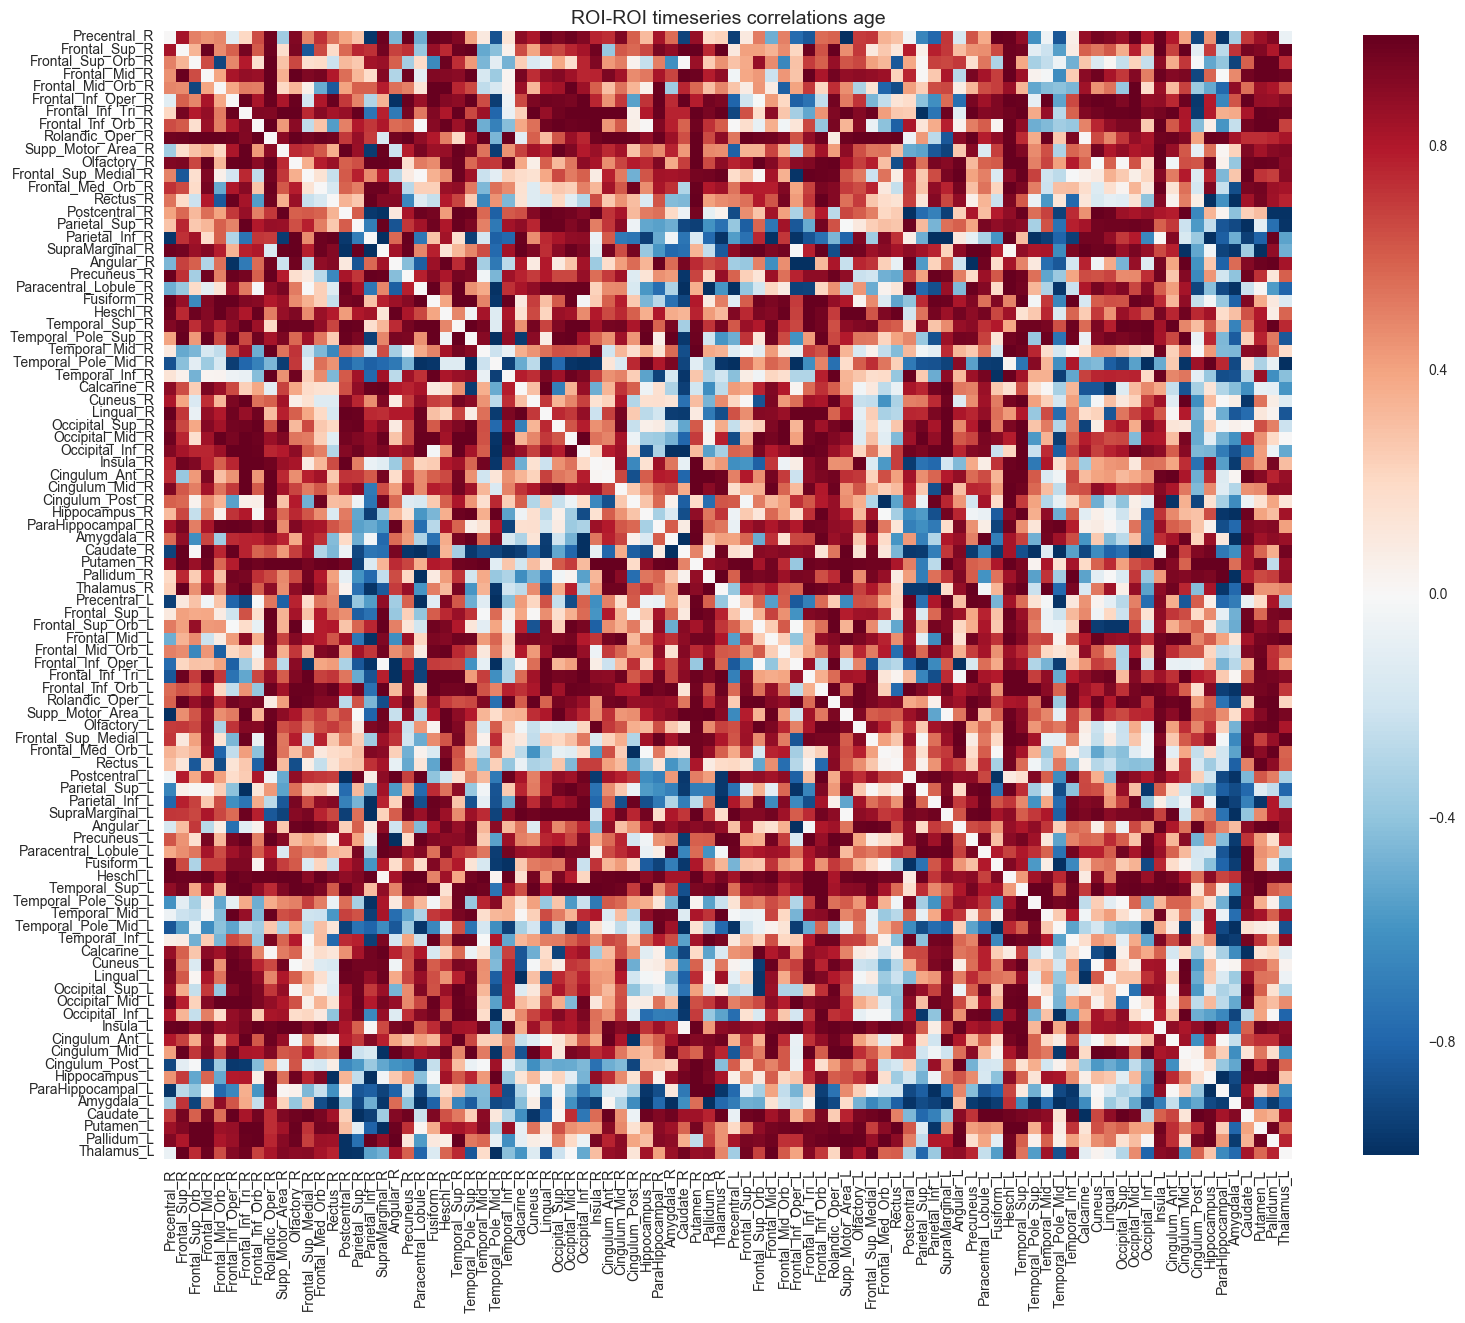

In [69]:
corr=age_roi_corr_r
import matplotlib.pyplot as plt
from matplotlib.colorbar import make_axes
sns.set(style="darkgrid")

sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 2.5})
f, ax = plt.subplots(figsize=(16, 16))
ax.set_title('ROI-ROI timeseries correlations age',fontdict={'fontsize': 14})
sns.color_palette("RdBu_r")
sns.heatmap(corr, square=True, ax=ax, xticklabels=list(labs),yticklabels=list(labs),cbar_kws={'shrink':0.73})
f.tight_layout()
f.savefig('rs_SSI_chart', dpi=600, frameon=False,transparent=True,edgecolor='k',facecolor='w')#facecolor='w', , pad_inches=5)